Soal 4.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
project_path = '/content/drive/MyDrive/Hands-On 3'
os.listdir(project_path)

['video1.mp4',
 'breath.csv',
 'output.avi',
 'readme.txt',
 'video_low_fps.mp4',
 '121140171_ho3.ipynb',
 '.ipynb_checkpoints',
 'frames',
 'asset']

In [ ]:
import cv2
import numpy as np

video_path = '/content/drive/MyDrive/Hands-On 3/video1.mp4'

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error opening video file")
    exit()

In [ ]:
fps = cap.get(cv2.CAP_PROP_FPS)

total_frames_to_read = int(fps * 20)

frames = []
frame_count = 0
while(cap.isOpened() and frame_count < total_frames_to_read):
    ret, frame = cap.read()
    if ret:
        frames.append(frame)
        frame_count += 1
    else:
        break

frames_array = np.array(frames)

cap.release()

In [ ]:
print(frames_array.shape)

(595, 1080, 1920, 3)


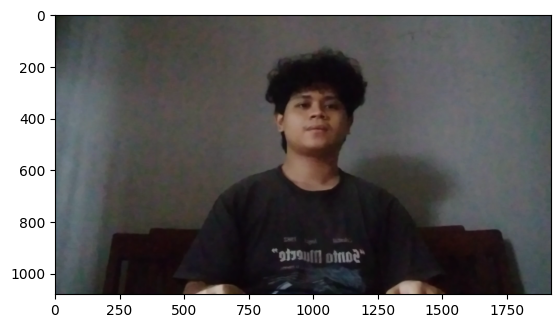

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

images_array = frames_array

import random
if images_array.size > 0:
  random_index = random.randint(0, len(images_array) - 1)

  random_image = images_array[random_index]

  plt.imshow(cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB))
  plt.show()
else:
    print("Tidak ada frame yang diekstrak dari video. images_array kosong.")

In [ ]:
import dlib
import cv2

detector = dlib.get_frontal_face_detector()
predictor = dlib
random_image = images_array[random_index]
faces = detector(random_image)

print(f"Jumlah wajah yang terdeteksi: {len(faces)}")

Jumlah wajah yang terdeteksi: 1


x,y,w,h: (847, 99, 322, 322)
x,y_edit,w,h_edit: (847, 49, 322, 483)


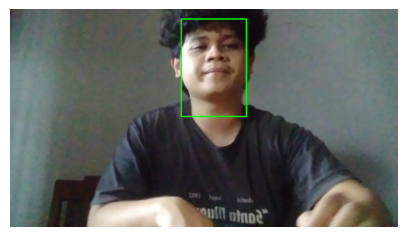

In [ ]:
import dlib
import cv2
import matplotlib.pyplot as plt

single_img = frames_array[1].copy()

# Convert single_img to RGB before face detection
single_img_rgb = cv2.cvtColor(single_img, cv2.COLOR_BGR2RGB)

faces = detector(single_img_rgb, 1)  # Use the RGB image for detection

for i, face in enumerate(faces):
    x, y, w, h = face.left(), face.top(), face.width(), face.height()
    print(f"x,y,w,h: {x, y, w, h}")

    y_edit = int(y - (0.5 * y))
    h_edit = int(h + (0.5 * h))
    print(f"x,y_edit,w,h_edit: {x, y_edit, w, h_edit}")

    # Draw rectangle on the original BGR image (single_img)
    cv2.rectangle(single_img, (x, y_edit), (x + w, y_edit + h_edit), (0, 255, 0), 5)

# Display the original BGR image with bounding box
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(single_img, cv2.COLOR_BGR2RGB)) # Convert to RGB for display
plt.axis('off')
plt.show()

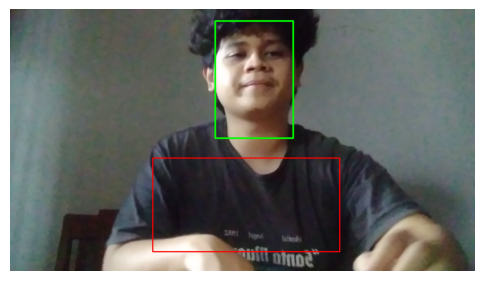

In [ ]:
# Asumsi 'faces' berisi kotak bounding box yang terdeteksi oleh dlib
for index, face_rect in enumerate(faces):
    face_x = face_rect.left()
    face_y = face_rect.top()
    face_width = face_rect.width()
    face_height = face_rect.height()

    # Sesuaikan ROI untuk mencakup area bahu hingga dada
    # Estimasi nilai ini berdasarkan proporsi wajah
    chest_start_y = int(face_y + face_height * 1.6)  # Turunkan lebih jauh ke bawah dari wajah
    chest_height = int(face_height * 1.2)           # Tambahkan tinggi untuk mencakup bahu dan dada
    chest_start_x = int(face_x - face_width * 0.8)  # Perluas ke kiri untuk mencakup bahu
    chest_width = int(face_width * 2.4)             # Perluas lebar untuk mencakup kedua bahu

    # Pastikan koordinat berada dalam batas gambar
    chest_start_y = max(0, chest_start_y)
    chest_height = min(single_img.shape[0] - chest_start_y, chest_height)
    chest_start_x = max(0, chest_start_x)
    chest_width = min(single_img.shape[1] - chest_start_x, chest_width)

    # Gambarkan kotak untuk ROI yang disesuaikan
    cv2.rectangle(
        single_img,
        (chest_start_x, chest_start_y),
        (chest_start_x + chest_width, chest_start_y + chest_height),
        (0, 0, 255),  # Warna merah
        thickness=4   # Ketebalan garis
    )

# Tampilkan gambar dengan ROI yang disesuaikan
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(single_img, cv2.COLOR_BGR2RGB))  # Konversi ke RGB untuk tampilan
plt.axis('off')
plt.show()


Soal 5.

In [ ]:
import os
import cv2
import dlib
import numpy as np
import datetime as dt

# Path ke video input dan output
video_path = "/content/drive/MyDrive/Hands-On 3/video1.mp4"  # Ganti dengan path video Anda
output_path = "/content/drive/MyDrive/Hands-On 3/roi_video1.mp4"

# Inisialisasi detektor wajah
face_detector = dlib.get_frontal_face_detector()

# Membuka video
video = cv2.VideoCapture(video_path)
video_fps = int(video.get(cv2.CAP_PROP_FPS))
frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Pengaturan output video
codec = cv2.VideoWriter_fourcc(*'mp4v')
output_video = cv2.VideoWriter(output_path, codec, video_fps, (frame_width, frame_height))

# Variabel untuk pelacakan wajah
roi_active = False
tracking_points = None
optical_flow_params = dict(winSize=(30, 30), maxLevel=3,
                           criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Interval deteksi ulang wajah (setiap 4 detik)
recheck_interval = video_fps * 4
frames_until_recheck = recheck_interval

# Proses hanya pada durasi antara 20-35 detik
start_frame = 20 * video_fps
end_frame = 35 * video_fps
current_frame_index = 0

# Catat waktu mulai untuk menghitung durasi proses
start_time = dt.datetime.now()

# Loop untuk membaca frame dari video
while video.isOpened():
    ret, current_frame = video.read()
    if not ret:
        break

    gray_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
    current_frame_index += 1

    # Abaikan frame sebelum durasi target
    if current_frame_index < start_frame:
        continue
    elif current_frame_index > end_frame:
        break

    # Deteksi ulang atau deteksi awal wajah
    if current_frame_index == start_frame or frames_until_recheck <= 0:
        detected_faces = face_detector(gray_frame, 1)
        if detected_faces:
            # Gunakan wajah pertama yang terdeteksi
            main_face = detected_faces[0]
            face_x, face_y, face_width, face_height = main_face.left(), main_face.top(), main_face.width(), main_face.height()
            cv2.rectangle(current_frame, (face_x, face_y), (face_x + face_width, face_y + face_height), (0, 255, 0), 2)

            # Inisialisasi poin pelacakan pada ROI wajah
            roi_gray = gray_frame[face_y:face_y + face_height, face_x:face_x + face_width]
            tracking_points = cv2.goodFeaturesToTrack(roi_gray, mask=None, maxCorners=15, qualityLevel=0.7, minDistance=5, blockSize=7)
            if tracking_points is not None:
                tracking_points[:, :, 0] += face_x
                tracking_points[:, :, 1] += face_y

            roi_active = True
            frames_until_recheck = recheck_interval
    else:
        # Lakukan pelacakan optical flow
        if roi_active and tracking_points is not None:
            new_points, status, error = cv2.calcOpticalFlowPyrLK(previous_gray, gray_frame, tracking_points, None, **optical_flow_params)
            if new_points is not None and status is not None:
                valid_new_points = new_points[status == 1]
                valid_old_points = tracking_points[status == 1]

                # Hitung perpindahan dengan rata-rata
                if len(valid_new_points) > 0:
                    x_shift = np.mean(valid_new_points[:, 0] - valid_old_points[:, 0])
                    y_shift = np.mean(valid_new_points[:, 1] - valid_old_points[:, 1])

                    # Perbarui posisi ROI
                    face_x = int(face_x + x_shift)
                    face_y = int(face_y + y_shift)

                    # Pastikan ROI tetap dalam batas gambar
                    face_x = max(0, min(face_x, frame_width - face_width))
                    face_y = max(0, min(face_y, frame_height - face_height))

                    # Gambar ROI yang diperbarui
                    cv2.rectangle(current_frame, (face_x, face_y), (face_x + face_width, face_y + face_height), (0, 255, 0), 2)

                # Perbarui titik pelacakan
                tracking_points = valid_new_points.reshape(-1, 1, 2)

    # Simpan frame ke output video
    output_video.write(current_frame)

    # Simpan frame sebelumnya untuk pelacakan optical flow
    previous_gray = gray_frame.copy()

    # Hitung mundur deteksi ulang
    frames_until_recheck -= 1

# Bersihkan resource
video.release()
output_video.release()

# Tampilkan waktu yang digunakan
print(f"Proses selesai. Video hasil disimpan di: {output_path}")
print(f"Waktu proses: {dt.datetime.now() - start_time}")


Proses selesai. Video hasil disimpan di: /content/drive/MyDrive/Hands-On 3/roi_video1.mp4
Waktu proses: 0:00:37.564461


Soal 6.

In [ ]:
!pip install mediapipe
import cv2
import mediapipe as mp
import numpy as np

# Path ke video input dan output
video_path = "/content/drive/MyDrive/Hands-On 3/video1.mp4"
output_video_path = "/content/drive/MyDrive/Hands-On 3/video1_overlay.mp4"
overlay_image_path = "/content/drive/MyDrive/Hands-On 3/red-dot.png"

# Inisialisasi Mediapipe untuk deteksi wajah
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True)

# Membuka video
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Konfigurasi untuk menyimpan video output
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Muat gambar overlay
overlay_image = cv2.imread(overlay_image_path, cv2.IMREAD_UNCHANGED)

# Pastikan gambar overlay dimuat dengan benar
if overlay_image is None:
    raise FileNotFoundError(f"Overlay image tidak ditemukan: {overlay_image_path}")

# Tambahkan kanal alpha jika overlay tidak memilikinya
if overlay_image.shape[2] != 4:
    b, g, r = cv2.split(overlay_image)
    alpha_channel = np.ones(b.shape, dtype=b.dtype) * 255
    overlay_image = cv2.merge((b, g, r, alpha_channel))

# Fungsi untuk menambahkan overlay ke frame
def apply_overlay(image, overlay, pos_x, pos_y, width, height):
    resized_overlay = cv2.resize(overlay, (width, height))
    for channel in range(3):  # Untuk setiap kanal warna (BGR)
        alpha = resized_overlay[:, :, 3] / 255.0
        image[pos_y:pos_y+height, pos_x:pos_x+width, channel] = (
            resized_overlay[:, :, channel] * alpha +
            image[pos_y:pos_y+height, pos_x:pos_x+width, channel] * (1 - alpha)
        )

# Proses frame video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Konversi frame ke RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Deteksi landmark wajah
    result = face_mesh.process(frame_rgb)
    if result.multi_face_landmarks:
        for face_landmarks in result.multi_face_landmarks:
            # Landmark ke-1 adalah ujung hidung
            nose_tip = face_landmarks.landmark[mp_face_mesh.FaceMeshLandmark.NOSE_TIP]
            nose_x = int(nose_tip.x * frame_width)
            nose_y = int(nose_tip.y * frame_height)

            # Ukuran overlay
            overlay_width = 60
            overlay_height = 60

            # Terapkan overlay
            apply_overlay(frame, overlay_image, nose_x - overlay_width // 2, nose_y - overlay_height // 2, overlay_width, overlay_height)

    # Simpan frame ke video output
    out.write(frame)

cap.release()
out.release()

print(f"Proses selesai. Video output disimpan di: {output_video_path}")
